In [1]:
import numpy as np
import anndata as ad
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Load data
input_dir = "/Users/apple/Desktop/KB/data/LarryData"
num_neighbor = 100
X_scCL = np.load("/Users/apple/Desktop/KB/data/feat_414/feat_414__bs25_temp0.1/scBaseEncoderFeat_Z_bs25_tau0.1.npy")
X_pca = np.load("/Users/apple/Desktop/KB/data/feat_612_scvi/Larry_scvi_kevin.npy")

adata_subset = ad.read_h5ad(input_dir+'/Larry_41201_2000.h5ad')
y = adata_subset.obs["clone_id"].to_numpy()

### KNN_Score function

In [3]:
def compute_scores(X, y, num_neighbors):
    # Convert y to a pandas Series
    y_series = pd.Series(y)
    
    # Initialize the KNN classifier with num_neighbors + 1 (including the point itself)
    knn = KNeighborsClassifier(n_neighbors=num_neighbors + 1)
    
    # Fit the classifier on the entire dataset
    knn.fit(X, y)
    
    # Finding the num_neighbors + 1 nearest neighbors for each point in X
    neighbors = knn.kneighbors(X, return_distance=False)
    
    # Count how many nearest neighbors have the same label as the point itself
    # Exclude the first neighbor (itself)
    correct_neighbors_count = np.array([np.sum(y[neighbors[i][1:]] == y[i]) for i in range(len(X))])
    
    # Calculate proportion of cells for each clone
    total_cells = len(y)
    clone_proportions = y_series.value_counts(normalize=True)
    
    # Calculate the Score_i for each cell
    scores = np.zeros(total_cells)  # Initialize scores array
    
    for i in range(total_cells):
        proportion_correct = correct_neighbors_count[i] / num_neighbors
        clone_size_proportion = clone_proportions[y[i]]
        if proportion_correct > 0:
            score_numerator = proportion_correct - clone_size_proportion
            if clone_size_proportion != 0:
                scores[i] = np.log2(score_numerator / clone_size_proportion)
            else:
                scores[i] = 0  # Avoid division by zero in case clone_size_proportion is 0
        else:
            scores[i] = 0
    
    return scores

### Compute the score

In [4]:
score_scCL = compute_scores(X_scCL,y,num_neighbor)
score_pca = compute_scores(X_pca,y,num_neighbor)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


#### calculate the average score for each lineage 

In [5]:
df_score_pca = pd.DataFrame({
    'clone_id': y,
    'score': score_pca
})
df_score_scCL = pd.DataFrame({
    'clone_id': y,
    'score': score_scCL
})

# Group by 'clone_id' and calculate the mean score for each clone
avg_lineage_pca = df_score_pca.groupby('clone_id')['score'].mean()
avg_lineage_scCL = df_score_scCL.groupby('clone_id')['score'].mean()

In [6]:
avg_lineage_pca.mean(), avg_lineage_scCL.mean()

(1.9766330415068707, 2.592950976252879)

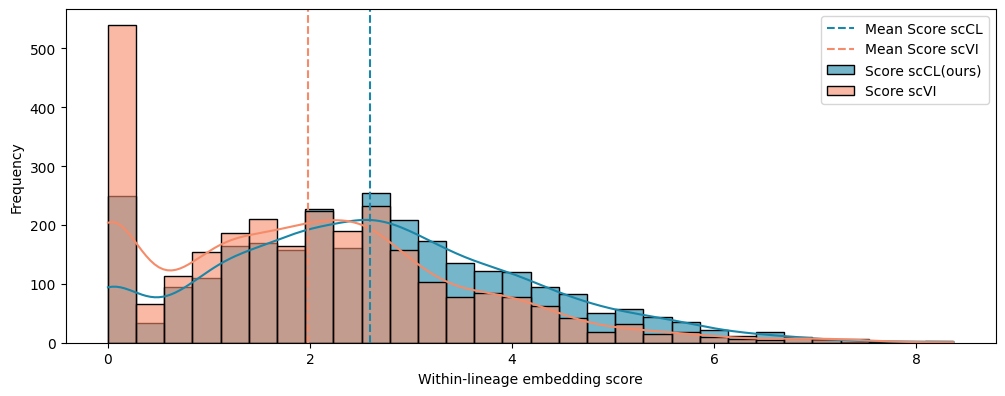

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming score_scCL and score_pca are both numpy arrays or lists containing the scores
#plt.figure(figsize=(12, 8*2/4.8))
plt.figure(figsize=(12, (8*2/4.8)+1))
sns.histplot(avg_lineage_scCL, color='#1A86A8', label="Score scCL(ours)", kde=True, bins=30, alpha=0.6)
sns.histplot(avg_lineage_pca, color='#F68B69', label="Score scVI", kde=True, bins=30, alpha=0.6)

# Assuming avg_lineage_scCL and avg_lineage_pca are defined and contain the scores
plt.axvline(avg_lineage_scCL.mean(), color='#1A86A8', linestyle='dashed', linewidth=1.5, label=f'Mean Score scCL')
plt.axvline(avg_lineage_pca.mean(), color='#F68B69', linestyle='dashed', linewidth=1.5, label=f'Mean Score scVI')
# plt.axvline(avg_lineage_scCL.mean(), color='#045275', linestyle='dashed', linewidth=1.5, label=f'Mean Score scCL: {avg_lineage_scCL.mean():.2f}')
# plt.axvline(avg_lineage_pca.mean(), color='#7CCBA2', linestyle='dashed', linewidth=1.5, label=f'Mean Score PCA: {avg_lineage_pca.mean():.2f}')


# plt.title('Comparison of Scores: scCL vs. PCA')
plt.xlabel('Within-lineage embedding score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('comparison_of_scores.png', dpi=300)
plt.show()

In [ ]:
avg_lineage_scCL_nonzero = avg_lineage_scCL[avg_lineage_scCL != 0]
avg_lineage_pca_nonzero = avg_lineage_pca[avg_lineage_pca != 0]
# Assuming score_scCL and score_pca are both numpy arrays or lists containing the scores
plt.figure(figsize=(12, 8))
sns.histplot(avg_lineage_scCL_nonzero, color="blue", label="Score scCL", kde=True, bins=30, alpha=0.6)
sns.histplot(avg_lineage_pca_nonzero, color="green", label="Score PCA", kde=True, bins=30, alpha=0.6)

plt.title('Comparison of Scores: scCL vs. PCA')
plt.xlabel('Score_lineage')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming score_scCL and score_pca are both numpy arrays or lists containing the scores
plt.figure(figsize=(12, 8))
sns.histplot(score_scCL, color="blue", label="Score scCL", kde=True, bins=30, alpha=0.6)
sns.histplot(score_pca, color="green", label="Score PCA", kde=True, bins=30, alpha=0.6)

plt.title('Comparison of Scores: scCL vs. PCA')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
score_pca_nonzero = score_pca[score_pca != 0]
score_scCL_nonzero = score_scCL[score_scCL != 0]

In [ ]:
score_pca_nonzero.mean(),score_scCL_nonzero.mean()

In [ ]:
len(score_pca[score_pca == 0])/len(pd.Series(y)),len(score_scCL[score_scCL == 0])/len(pd.Series(y))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming score_scCL and score_pca are both numpy arrays or lists containing the scores
plt.figure(figsize=(12, 8))
sns.histplot(score_scCL_nonzero, color="blue", label="Score scCL", kde=True, bins=30, alpha=0.6)
sns.histplot(score_pca_nonzero, color="green", label="Score PCA", kde=True, bins=30, alpha=0.6)

plt.title('Comparison of Scores: scCL vs. PCA')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()
